# QuantumSim - Decomposition of multi-qubit controlled X and Z gates
Author: Nico Kuijpers<br>
Date: October 23, 2024<br>

Many quantum algorithms require multi-qubit controlled gates. 
In Grover's algorithm both a multi-qubit controlled X gate and a multi-qubit controlled Z gate are applied. Naive implementations are provided in QuantumSim by functions *multi_controlled_pauli_X()* and *multi_controlled_pauli_Z()* of class *Circuit*. However, when effects of decoherence and quantum noise are to be investigated, the algorithm should be described in basic gates. 

Here, we introduce a decomposition of the multi-qubit controlled X and Z gates, and we apply this decomposition to Grover's algorithm.

The proposed decomposition is adapted from: 

Adenilton J. Silva and Daniel K. Park<br>
Linear-depth quantum circuits for multi-qubit controlled gates<br>
preprint March 2022<br>
DOI: 10.48550/arXiv.2203.11882<br>
https://www.researchgate.net/publication/359411071_Linear-depth_quantum_circuits_for_multi-qubit_controlled_gates

In this notebook we will use QuantumSim.

In [1]:
from quantumsim import *

## Decomposition of multi-qubit controlled X and Z gates

In the figure below a linear-depth decomposition of a multi-qubit controlled unitary (qubit) operation is shown. This figure is adapted from Silva and Park (see reference above).

![Figure 1 of Silva and Park](./assets/images/LinearDepthDecomposition.png)

In this figure, $\pi/k$ in the boxes indicate the angle of rotation around the x-axis, i.e., $R_X(\theta)$ with $\theta = \pi/k$. 
$\sqrt[k]{U}$ represents the $n$-th root of unitary (qubit) operation $U$ and $\sqrt[k]{U}^{\dagger}$ its conjugate transpose (or adjoint).
The numbers to the left side of each box correspond to the time step at which the gate is applied. Thus, some gates can be applied in parallel reducing the total depth of the circuit.

In this notebook we introduce multi-qubit controlled X and Z gates based on the figure above. In our case, $U=X$ or $U=Z$, where $X$ and $Z$ represent the Pauli-X and Pauli-Z matrices. $\sqrt[k]{U}$ and $\sqrt[k]{U}^{\dagger}$ are then replaced by

\begin{align}
\sqrt[k]{X} &= R_X(\pi/k)\\
\sqrt[k]{X}^{\dagger} &= R_X(-\pi/k)\\
\sqrt[k]{Z} &= R_Z(\pi/k)\\
\sqrt[k]{Z}^{\dagger} &= R_Z(-\pi/k)
\end{align}

Below, function *decompose_multi_controlled_gate()* is defined. Parameter *gate* is a string and must be "X" or "Z". Parameter *circuit* is the circuit to which the decomposed version of the multi-qubit controlled X or Z-gate must be applied.

In [2]:
def decompose_multi_controlled_gate(gate:str, circuit:Circuit):
    # Gate "X" and "Z" are supported
    if not(gate == "X" or gate == "Z"):
        raise ValueError("String gate must be X or Z")
    N = circuit.N
    # Left part in figure
    for i in range(N-2):
        control = N-i-2
        for j in range(i+1):
            target = N-i+j-1
            theta = np.pi/2**(target-control)
            if target != N-1 or gate == "X":
                circuit.controlled_rotate_x(theta,control,target)
            else:
                circuit.controlled_rotate_z(theta,control,target)
                
    for j in range(N-1):
        control = 0
        target = j+1
        theta = np.pi/2**(target-control-1)
        if target != N-1 or gate == "X":
            circuit.controlled_rotate_x(theta,control,target)
        else:
            circuit.controlled_rotate_z(theta,control,target)

    for i in range(N-2):
        control = i+1
        for j in range(N-i-2):
            target = i+j+2
            theta = -np.pi/2**(target-control)
            if target != N-1 or gate == "X":
                circuit.controlled_rotate_x(theta,control,target)
            else:
                circuit.controlled_rotate_z(theta,control,target)

    # Right part in figure
    for i in range(N-3):
        control = N-i-3
        for j in range(i+1):
            target = N-i+j-2
            theta = np.pi/2**(target-control)
            circuit.controlled_rotate_x(theta,control,target)
    for j in range(N-2):
        control = 0
        target = j+1
        theta = -np.pi/2**(target-control-1)
        circuit.controlled_rotate_x(theta,control,target)
    for i in range(N-3):
        control = i+1
        for j in range(N-i-3):
            target = i+j+2
            theta = -np.pi/2**(target-control)
            circuit.controlled_rotate_x(theta,control,target)

## Example decomposed multi-qubit controlled X gate

Below, a circuit of $N$ qubits is defined. The Pauli X (or NOT) operation is applied to qubits $0$ through $N-2$ to bring them in state $|1\rangle$. Next, function *decompose_multi_controlled_gate()* is called and a decomposition of the multi-qubit controlled X gate is applied to the circuit.

Upon measurement, target qubit $N-2$ will be in state $|1\rangle$, since all control qubits $0$ through $N-2$ are in state $|1\rangle$.

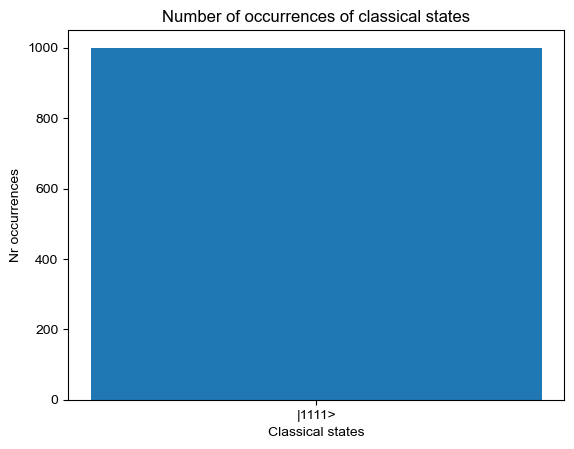

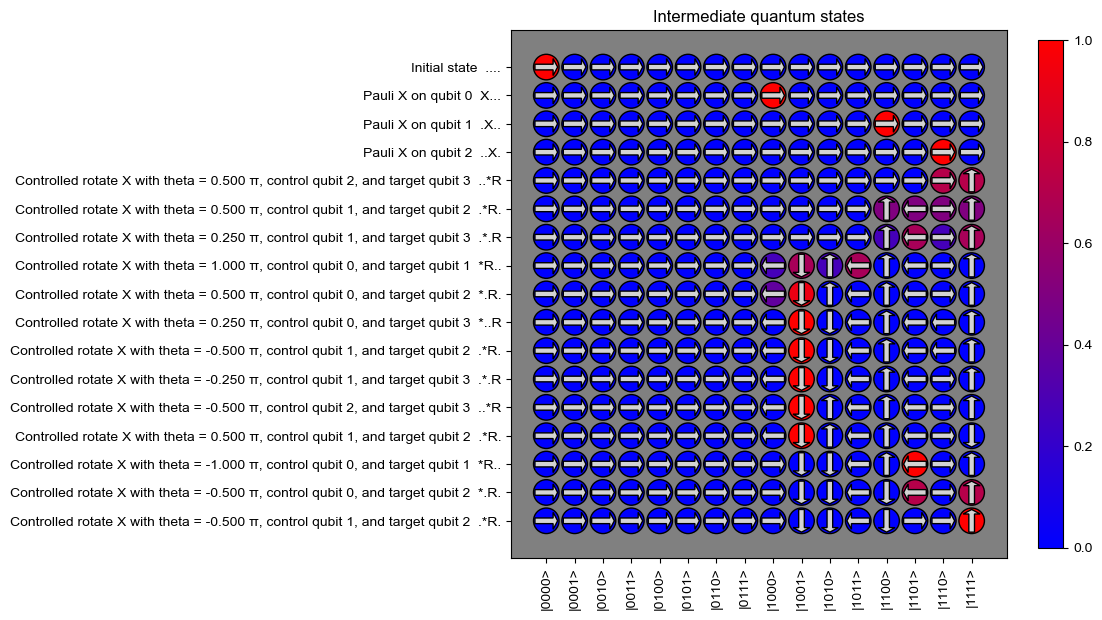

In [3]:
N = 4
circuit = Circuit(N)
for q in range(0,N-1):
    circuit.pauli_x(q)
decompose_multi_controlled_gate("X",circuit)
result = QuantumUtil.measure_circuit(circuit)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.show_all_intermediate_states(circuit)

## Example decomposed multi-qubit controlled Z gate

Below, a circuit of $N$ qubits is defined. The Pauli X (or NOT) operation is applied to qubits $0$ through $N-2$ to bring them in state $|1\rangle$. To see effect of rotation about the $z$-axis, the Hadamard gate is applied to qubit $N-1$. Finally, function *decompose_multi_controlled_gate()* is called and a decomposition of the multi-qubit controlled Z gate is applied to the circuit.

An animation of Bloch spheres is used to visualize the effect of applying a multi-qubit controlled Z gate to qubit $N-1$.

Note that creating the animation may take some time, especially for larger values of $N$.

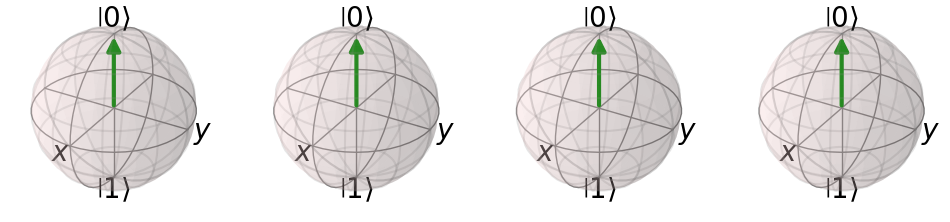

In [4]:
from IPython.display import HTML

N = 4
circuit = NoisyCircuit(N)
for q in range(0,N-1):
    circuit.pauli_x(q)
circuit.hadamard(N-1)
decompose_multi_controlled_gate("Z",circuit)
result = QuantumUtil.measure_circuit(circuit)

ani_bloch_spheres = QuantumUtil.create_animation(circuit)
HTML(ani_bloch_spheres.to_jshtml())

## Grover's Algorithm revisited

An implementation of Grover's search algorithm using QuantumSim is given here:

https://github.com/nicokuijpers/QuantumSim/blob/main/QuantumSimGroverAlgorithm.ipynb

Below, the same code is used, but with function calls *circuit.multi_controlled_pauli_x()* and *circuit.multi_controlled_pauli_z()* replaced with
function calls of *decompose_multi_controlled_gate()* as defined above.

In [5]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        Circuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    # Create the circuit
    circuit = Circuit(num_qubits)

    # Mark each target state in the input list
    for target in marked_states:
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if target.startswith("0",ind)]

        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        for i in zero_inds:
            circuit.pauli_x(i)
        # circuit.multi_controlled_pauli_z()
        decompose_multi_controlled_gate("Z",circuit) 
        for i in zero_inds:
            circuit.pauli_x(i)

    return circuit

In [6]:
def grover_operator(oracle:Circuit):
    grover = Circuit(oracle.N)
    grover.append_circuit(oracle)
    for q in range (grover.N):
        grover.hadamard(q)
    for q in range (grover.N):
        grover.pauli_x(q)
    grover.hadamard(grover.N - 1)
    # grover.multi_controlled_pauli_x()
    decompose_multi_controlled_gate("X",grover)
    grover.hadamard(grover.N - 1)
    for q in range (grover.N):
        grover.pauli_x(q)
    for q in range (grover.N):
        grover.hadamard(q)
    return grover

In [7]:
def optimal_num_iterations(marked_states):
    return max(1,math.floor(math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**len(marked_states[0]))))))

In [8]:
def create_grover_circuit(marked_states):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    nr_iterations = optimal_num_iterations(marked_states)
    oracle = grover_oracle(marked_states)
    circuit = Circuit(oracle.N)
    circuit_grover_operator = grover_operator(oracle)
    for q in range(oracle.N):
        circuit.hadamard(q)
    for i in range(nr_iterations):
        circuit.append_circuit(circuit_grover_operator)
    return circuit

In [9]:
#marked_states = ["00"] # 1 iteration, output correct
#marked_states = ["01"] # 1 iteration, output correct
#marked_states = ["01","10"] # 1 iteration, gives all possible states as output
#marked_states = ["01","10","11"] # 1 iteration, gives output |00>
#marked_states = ["000","111"] # 1 iteration
#marked_states = ["100","101"] # 1 iteration
#marked_states = ["100"] # 2 iterations
#marked_states = ["1010"] # 3 iterations
#marked_states = ["0101","1010"] # 2 iterations
#marked_states = ["0001","0010","0100","1000"] # 1 iteration
#marked_states = ["0000","0001","0011","0111","1111"] # 1 iteration
#marked_states = ["01010","01011","01110","10101"] # 2 iterarations
marked_states = ["01011","10101"] # 3 iterarations
#marked_states = ["01011"] # 4 iterarations

In [10]:
nr_iterations = optimal_num_iterations(marked_states)
print(f"Nr iterations is {nr_iterations} for marked states {marked_states}")

Nr iterations is 3 for marked states ['01011', '10101']


In [11]:
circuit = create_grover_circuit(marked_states)

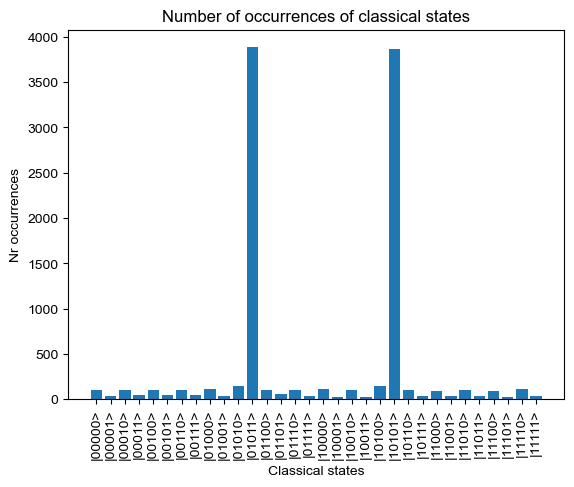

In [12]:
result = QuantumUtil.measure_circuit(circuit, nr_measurements=10000)
QuantumUtil.histogram_of_classical_states(result)